##### [this demo requires doom installed either officially or from gym-pool. Or simply use https://github.com/justheuristic/doomed_dqn]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="device=cpu"

%env OPENMP_NUM_THREADS=6

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="device=cpu"
env: OPENMP_NUM_THREADS=6


In [2]:
from scipy.misc import imresize
#game image will be resized from(96,128) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN

IMAGE_W,IMAGE_H = IMAGE_SIZE =(60,80)#(96,128)
def preprocess(obs):
    return (imresize(obs,IMAGE_SIZE).mean(-1)/255.)

class Frameskipper:
    def __init__(self,env,frameskip=4):
        self.env=env
        self.frameskip=frameskip
    def step(self,action):
        
        total_reward = 0.
        for i in range(self.frameskip):
            obs,r,done,info = self.env.step(action)
            total_reward += r
            if done: break
        
        return obs,total_reward,done,info
    def __getattr__(self,attr):
        if attr == 'step':
            return self.step
        else:
            return getattr(self.env,attr)
        
        
            
        
        

In [3]:
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
GAME_NAME = 'ppaquette/DoomBasic-v0'
env = Frameskipper(ToDiscrete("minimal")(gym.make(GAME_NAME)))

[2016-11-28 00:34:46,219] Making new env: ppaquette/DoomBasic-v0


In [4]:
#global params.

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 5

-4.0 False


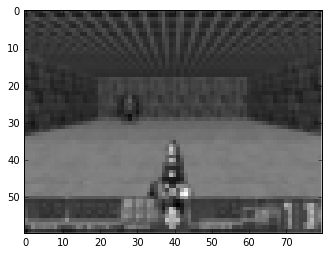

In [5]:
env.reset()
obs,r,done,_=env.step(1)
print r, done
plt.imshow(preprocess(obs),cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [6]:
import lasagne

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
from lasagne.layers import *
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H))

In [8]:
from agentnet.memory import WindowAugmentation,LSTMCell,RNNCell

#store 4-tick window in order to perceive motion of objects

prev_window = InputLayer((None,4,IMAGE_W,IMAGE_H))

current_window = WindowAugmentation(observation_layer,prev_window)

In [9]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(current_window,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense0 = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [10]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


In [11]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer,dense0)


In [12]:
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [13]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={current_window:prev_window},
              action_layers=action_layer)


In [14]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [15]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,lambda:Frameskipper(ToDiscrete("minimal")(gym.make(GAME_NAME))), 
               preprocess_observation=preprocess,
               n_games=N_AGENTS,max_size=1000) #may need to adjust for speed


[2016-11-28 00:34:49,377] Making new env: ppaquette/DoomBasic-v0


In [16]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[0 0 3 0 0 0 0]]
[[-4. -4. -4. -4. -4. -4.  0.]]
CPU times: user 317 ms, sys: 453 ms, total: 769 ms
Wall time: 125 ms


In [17]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [18]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay#.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [19]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      Qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.95,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [20]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

In [21]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [22]:
action_layer.epsilon.set_value(0)

In [23]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-11-28 00:35:00,498] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:35:00,512] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-11-28 00:35:00,751] Starting new video recorder writing to /root/drqn/records/openaigym.video.0.18681.video000000.mp4
[2016-11-28 00:35:03,428] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-350.0


In [24]:
from IPython.display import HTML

video_path="records/openaigym.video.94.4407.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [25]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [26]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**7):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(1): #you may want to increase the number of training iterations per one update
        loss = train_step()
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
#         plt.title("random frames")
#         for i in range(min((len(pool.games),6))):
#             plt.subplot(2,3,i+1)
#             plt.imshow(pool.games[i].get_observation())
#         plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

iter=10	epsilon=0.954	reward/step=-1.50909
iter=20	epsilon=0.910	reward/step=-1.52381
iter=30	epsilon=0.868	reward/step=-2.29032
iter=40	epsilon=0.828	reward/step=-2.58049
iter=50	epsilon=0.790	reward/step=-2.37647
iter=60	epsilon=0.754	reward/step=-2.60984
iter=70	epsilon=0.719	reward/step=-2.44225
iter=80	epsilon=0.687	reward/step=-2.06420
iter=90	epsilon=0.656	reward/step=-2.27692


[2016-11-28 00:35:34,193] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:35:34,200] Clearing 4 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=-2.42574


[2016-11-28 00:35:35,780] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-400.0
iter=110	epsilon=0.598	reward/step=-2.54054
iter=120	epsilon=0.571	reward/step=-2.63471
iter=130	epsilon=0.546	reward/step=-2.69313
iter=140	epsilon=0.522	reward/step=-2.76454
iter=150	epsilon=0.499	reward/step=-2.66225
iter=160	epsilon=0.477	reward/step=-2.58012
iter=170	epsilon=0.456	reward/step=-2.53099
iter=180	epsilon=0.436	reward/step=-2.36243
iter=190	epsilon=0.417	reward/step=-2.33298


[2016-11-28 00:36:46,046] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:36:46,054] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=-2.39602


[2016-11-28 00:36:47,622] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-380.0
iter=210	epsilon=0.382	reward/step=-2.46730
iter=220	epsilon=0.366	reward/step=-2.50860
iter=230	epsilon=0.351	reward/step=-2.55584
iter=240	epsilon=0.336	reward/step=-2.59834
iter=250	epsilon=0.322	reward/step=-2.64223
iter=260	epsilon=0.309	reward/step=-2.67816
iter=270	epsilon=0.296	reward/step=-2.71587
iter=280	epsilon=0.284	reward/step=-2.74662
iter=290	epsilon=0.273	reward/step=-2.77251


[2016-11-28 00:38:37,277] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:38:37,285] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=-2.79668


[2016-11-28 00:38:38,771] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-405.0
iter=310	epsilon=0.252	reward/step=-2.60000
iter=320	epsilon=0.242	reward/step=-2.63801
iter=330	epsilon=0.232	reward/step=-2.68520
iter=340	epsilon=0.224	reward/step=-2.58299
iter=350	epsilon=0.215	reward/step=-2.42165
iter=360	epsilon=0.207	reward/step=-2.45152
iter=370	epsilon=0.199	reward/step=-2.48518
iter=380	epsilon=0.192	reward/step=-2.51654
iter=390	epsilon=0.185	reward/step=-2.54680


[2016-11-28 00:41:07,348] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:41:07,355] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=-2.47332


[2016-11-28 00:41:08,948] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-455.0
iter=410	epsilon=0.172	reward/step=-2.45450
iter=420	epsilon=0.166	reward/step=-2.49121
iter=430	epsilon=0.161	reward/step=-2.47146
iter=440	epsilon=0.155	reward/step=-2.44354
iter=450	epsilon=0.150	reward/step=-2.47140
iter=460	epsilon=0.145	reward/step=-2.49111
iter=470	epsilon=0.141	reward/step=-2.46030
iter=480	epsilon=0.136	reward/step=-2.48191
iter=490	epsilon=0.132	reward/step=-2.37067


[2016-11-28 00:44:18,782] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:44:18,788] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=-2.35010


[2016-11-28 00:44:19,556] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 37 timesteps with reward=-74.0
iter=510	epsilon=0.124	reward/step=-2.25245
iter=520	epsilon=0.121	reward/step=-2.24568
iter=530	epsilon=0.117	reward/step=-2.27119
iter=540	epsilon=0.114	reward/step=-2.17116
iter=550	epsilon=0.111	reward/step=-2.16624
iter=560	epsilon=0.108	reward/step=-2.15330
iter=570	epsilon=0.105	reward/step=-2.05990
iter=580	epsilon=0.102	reward/step=-2.04578
iter=590	epsilon=0.100	reward/step=-2.03959


[2016-11-28 00:48:08,416] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:48:08,423] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=-1.95840


[2016-11-28 00:48:09,985] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-360.0
iter=610	epsilon=0.095	reward/step=-1.94828
iter=620	epsilon=0.093	reward/step=-1.97649
iter=630	epsilon=0.091	reward/step=-1.96450
iter=640	epsilon=0.089	reward/step=-1.91950
iter=650	epsilon=0.087	reward/step=-1.93917
iter=660	epsilon=0.085	reward/step=-1.96097
iter=670	epsilon=0.083	reward/step=-1.98241
iter=680	epsilon=0.082	reward/step=-2.00881
iter=690	epsilon=0.080	reward/step=-2.00521


[2016-11-28 00:52:44,409] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:52:44,415] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=-2.03081


[2016-11-28 00:52:46,227] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-355.0
iter=710	epsilon=0.077	reward/step=-2.01800
iter=720	epsilon=0.076	reward/step=-2.03856
iter=730	epsilon=0.075	reward/step=-2.00137
iter=740	epsilon=0.073	reward/step=-2.02564
iter=750	epsilon=0.072	reward/step=-1.98855
iter=760	epsilon=0.071	reward/step=-1.89698
iter=770	epsilon=0.070	reward/step=-1.91647
iter=780	epsilon=0.069	reward/step=-1.93803
iter=790	epsilon=0.068	reward/step=-1.87560


[2016-11-28 00:58:48,343] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 00:58:48,350] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=-1.89463


[2016-11-28 00:58:48,651] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 2 timesteps with reward=96.0
iter=810	epsilon=0.067	reward/step=-1.88607
iter=820	epsilon=0.066	reward/step=-1.87722
iter=830	epsilon=0.065	reward/step=-1.89434
iter=840	epsilon=0.064	reward/step=-1.89132
iter=850	epsilon=0.064	reward/step=-1.88719
iter=860	epsilon=0.063	reward/step=-1.88432
iter=870	epsilon=0.062	reward/step=-1.90402
iter=880	epsilon=0.062	reward/step=-1.90261
iter=890	epsilon=0.061	reward/step=-1.92166


[2016-11-28 01:05:29,036] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:05:29,043] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=-1.91387


[2016-11-28 01:05:29,359] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 2 timesteps with reward=96.0
iter=910	epsilon=0.060	reward/step=-1.93238
iter=920	epsilon=0.060	reward/step=-1.94940
iter=930	epsilon=0.059	reward/step=-1.92009
iter=940	epsilon=0.059	reward/step=-1.93900
iter=950	epsilon=0.058	reward/step=-1.95415
iter=960	epsilon=0.058	reward/step=-1.90718
iter=970	epsilon=0.057	reward/step=-1.89928
iter=980	epsilon=0.057	reward/step=-1.91254
iter=990	epsilon=0.057	reward/step=-1.92735


[2016-11-28 01:12:59,755] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:12:59,762] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=-1.91920


[2016-11-28 01:13:01,604] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-390.0
iter=1010	epsilon=0.056	reward/step=-1.94280
iter=1020	epsilon=0.056	reward/step=-1.95920
iter=1030	epsilon=0.056	reward/step=-1.91540
iter=1040	epsilon=0.055	reward/step=-1.81100
iter=1050	epsilon=0.055	reward/step=-1.83860
iter=1060	epsilon=0.055	reward/step=-1.83960
iter=1070	epsilon=0.055	reward/step=-1.83860
iter=1080	epsilon=0.054	reward/step=-1.88380
iter=1090	epsilon=0.054	reward/step=-1.88480


[2016-11-28 01:21:04,315] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:21:04,321] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=-1.88580


[2016-11-28 01:21:05,840] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-445.0
iter=1110	epsilon=0.054	reward/step=-1.86760
iter=1120	epsilon=0.054	reward/step=-1.87280
iter=1130	epsilon=0.053	reward/step=-1.87660
iter=1140	epsilon=0.053	reward/step=-1.79000
iter=1150	epsilon=0.053	reward/step=-1.74940
iter=1160	epsilon=0.053	reward/step=-1.77300
iter=1170	epsilon=0.053	reward/step=-1.72480
iter=1180	epsilon=0.053	reward/step=-1.69720
iter=1190	epsilon=0.052	reward/step=-1.64840


[2016-11-28 01:29:04,844] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:29:04,858] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=-1.64740


[2016-11-28 01:29:05,222] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 4 timesteps with reward=88.0
iter=1210	epsilon=0.052	reward/step=-1.61880
iter=1220	epsilon=0.052	reward/step=-1.57380
iter=1230	epsilon=0.052	reward/step=-1.46460
iter=1240	epsilon=0.052	reward/step=-1.37440
iter=1250	epsilon=0.052	reward/step=-1.30660
iter=1260	epsilon=0.052	reward/step=-1.30480
iter=1270	epsilon=0.052	reward/step=-1.27800
iter=1280	epsilon=0.052	reward/step=-1.16760
iter=1290	epsilon=0.052	reward/step=-1.09980


[2016-11-28 01:37:30,494] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:37:30,504] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=-1.07520


[2016-11-28 01:37:30,911] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 8 timesteps with reward=72.0
iter=1310	epsilon=0.051	reward/step=-1.14240
iter=1320	epsilon=0.051	reward/step=-1.11440
iter=1330	epsilon=0.051	reward/step=-1.10440
iter=1340	epsilon=0.051	reward/step=-1.12160
iter=1350	epsilon=0.051	reward/step=-1.09800
iter=1360	epsilon=0.051	reward/step=-1.03220
iter=1370	epsilon=0.051	reward/step=-0.98700
iter=1380	epsilon=0.051	reward/step=-0.87520
iter=1390	epsilon=0.051	reward/step=-0.76360


[2016-11-28 01:45:44,378] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:45:44,391] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=-0.67000


[2016-11-28 01:45:44,859] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 9 timesteps with reward=68.0
iter=1410	epsilon=0.051	reward/step=-0.66540
iter=1420	epsilon=0.051	reward/step=-0.63860
iter=1430	epsilon=0.051	reward/step=-0.52540
iter=1440	epsilon=0.051	reward/step=-0.48160
iter=1450	epsilon=0.051	reward/step=-0.46000
iter=1460	epsilon=0.051	reward/step=-0.32940
iter=1470	epsilon=0.051	reward/step=-0.30900
iter=1480	epsilon=0.051	reward/step=-0.24360
iter=1490	epsilon=0.051	reward/step=-0.22100


[2016-11-28 01:53:56,157] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 01:53:56,164] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=-0.19740


[2016-11-28 01:53:56,699] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 11 timesteps with reward=52.0
iter=1510	epsilon=0.050	reward/step=-0.19100
iter=1520	epsilon=0.050	reward/step=-0.14420
iter=1530	epsilon=0.050	reward/step=-0.10000
iter=1540	epsilon=0.050	reward/step=-0.09960
iter=1550	epsilon=0.050	reward/step=-0.04780
iter=1560	epsilon=0.050	reward/step=-0.00680
iter=1570	epsilon=0.050	reward/step=-0.02760
iter=1580	epsilon=0.050	reward/step=0.01300
iter=1590	epsilon=0.050	reward/step=0.01940


[2016-11-28 02:01:48,567] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:01:48,575] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.02180


[2016-11-28 02:01:50,092] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 88 timesteps with reward=-425.0
iter=1610	epsilon=0.050	reward/step=0.08420
iter=1620	epsilon=0.050	reward/step=0.21880
iter=1630	epsilon=0.050	reward/step=0.34860
iter=1640	epsilon=0.050	reward/step=0.39220
iter=1650	epsilon=0.050	reward/step=0.52180
iter=1660	epsilon=0.050	reward/step=0.60840
iter=1670	epsilon=0.050	reward/step=0.71740
iter=1680	epsilon=0.050	reward/step=0.82660
iter=1690	epsilon=0.050	reward/step=0.89760


[2016-11-28 02:08:39,655] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:08:39,662] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.96640


[2016-11-28 02:08:40,023] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 8 timesteps with reward=72.0
iter=1710	epsilon=0.050	reward/step=1.02960
iter=1720	epsilon=0.050	reward/step=1.16220
iter=1730	epsilon=0.050	reward/step=1.25160
iter=1740	epsilon=0.050	reward/step=1.36560
iter=1750	epsilon=0.050	reward/step=1.43240
iter=1760	epsilon=0.050	reward/step=1.43600
iter=1770	epsilon=0.050	reward/step=1.58920
iter=1780	epsilon=0.050	reward/step=1.67960
iter=1790	epsilon=0.050	reward/step=1.70300


[2016-11-28 02:15:28,151] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:15:28,158] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=1.79040


[2016-11-28 02:15:28,572] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 11 timesteps with reward=55.0
iter=1810	epsilon=0.050	reward/step=1.87740
iter=1820	epsilon=0.050	reward/step=1.96400
iter=1830	epsilon=0.050	reward/step=2.07140
iter=1840	epsilon=0.050	reward/step=2.16380
iter=1850	epsilon=0.050	reward/step=2.23140
iter=1860	epsilon=0.050	reward/step=2.30060
iter=1870	epsilon=0.050	reward/step=2.38940
iter=1880	epsilon=0.050	reward/step=2.37120
iter=1890	epsilon=0.050	reward/step=2.46060


[2016-11-28 02:22:17,122] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:22:17,129] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=2.54740


[2016-11-28 02:22:17,435] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 4 timesteps with reward=88.0
iter=1910	epsilon=0.050	reward/step=2.57000
iter=1920	epsilon=0.050	reward/step=2.63300
iter=1930	epsilon=0.050	reward/step=2.70200
iter=1940	epsilon=0.050	reward/step=2.74820
iter=1950	epsilon=0.050	reward/step=2.83640
iter=1960	epsilon=0.050	reward/step=2.82100
iter=1970	epsilon=0.050	reward/step=2.81900
iter=1980	epsilon=0.050	reward/step=2.92400
iter=1990	epsilon=0.050	reward/step=2.96700


[2016-11-28 02:29:05,160] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:29:05,167] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=3.03280


[2016-11-28 02:29:05,538] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 8 timesteps with reward=72.0
iter=2010	epsilon=0.050	reward/step=3.07500
iter=2020	epsilon=0.050	reward/step=3.11380
iter=2030	epsilon=0.050	reward/step=3.07600
iter=2040	epsilon=0.050	reward/step=2.99300
iter=2050	epsilon=0.050	reward/step=2.99800
iter=2060	epsilon=0.050	reward/step=3.00520
iter=2070	epsilon=0.050	reward/step=3.02260
iter=2080	epsilon=0.050	reward/step=3.15680
iter=2090	epsilon=0.050	reward/step=3.24820


[2016-11-28 02:36:24,056] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:36:24,064] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2100	epsilon=0.050	reward/step=3.36080


[2016-11-28 02:36:24,508] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 10 timesteps with reward=64.0
iter=2110	epsilon=0.050	reward/step=3.43380
iter=2120	epsilon=0.050	reward/step=3.52820
iter=2130	epsilon=0.050	reward/step=3.61660
iter=2140	epsilon=0.050	reward/step=3.66460
iter=2150	epsilon=0.050	reward/step=3.68720
iter=2160	epsilon=0.050	reward/step=3.73540
iter=2170	epsilon=0.050	reward/step=3.73540
iter=2180	epsilon=0.050	reward/step=3.79800
iter=2190	epsilon=0.050	reward/step=3.86320


[2016-11-28 02:44:14,261] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:44:14,267] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2200	epsilon=0.050	reward/step=4.01380


[2016-11-28 02:44:14,582] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 2 timesteps with reward=96.0
iter=2210	epsilon=0.050	reward/step=4.07480
iter=2220	epsilon=0.050	reward/step=4.04560
iter=2230	epsilon=0.050	reward/step=4.02400
iter=2240	epsilon=0.050	reward/step=4.06380
iter=2250	epsilon=0.050	reward/step=4.15220
iter=2260	epsilon=0.050	reward/step=4.26120
iter=2270	epsilon=0.050	reward/step=4.36600
iter=2280	epsilon=0.050	reward/step=4.34340
iter=2290	epsilon=0.050	reward/step=4.36300


[2016-11-28 02:52:49,363] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 02:52:49,370] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2300	epsilon=0.050	reward/step=4.35600


[2016-11-28 02:52:49,685] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 2 timesteps with reward=96.0
iter=2310	epsilon=0.050	reward/step=4.35200
iter=2320	epsilon=0.050	reward/step=4.39620
iter=2330	epsilon=0.050	reward/step=4.48060
iter=2340	epsilon=0.050	reward/step=4.56340
iter=2350	epsilon=0.050	reward/step=4.58500
iter=2360	epsilon=0.050	reward/step=4.67180
iter=2370	epsilon=0.050	reward/step=4.71500
iter=2380	epsilon=0.050	reward/step=4.71500
iter=2390	epsilon=0.050	reward/step=4.73420


[2016-11-28 03:01:54,814] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 03:01:54,820] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2400	epsilon=0.050	reward/step=4.73260


[2016-11-28 03:01:55,244] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 8 timesteps with reward=72.0
iter=2410	epsilon=0.050	reward/step=4.83980
iter=2420	epsilon=0.050	reward/step=4.92660
iter=2430	epsilon=0.050	reward/step=4.90440
iter=2440	epsilon=0.050	reward/step=4.89880
iter=2450	epsilon=0.050	reward/step=4.98840
iter=2460	epsilon=0.050	reward/step=4.94680
iter=2470	epsilon=0.050	reward/step=5.01180
iter=2480	epsilon=0.050	reward/step=5.01060
iter=2490	epsilon=0.050	reward/step=5.02680


[2016-11-28 03:10:06,928] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 03:10:06,935] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	epsilon=0.050	reward/step=5.06880


[2016-11-28 03:10:07,344] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 8 timesteps with reward=65.0
iter=2510	epsilon=0.050	reward/step=5.10920
iter=2520	epsilon=0.050	reward/step=5.11060
iter=2530	epsilon=0.050	reward/step=5.06940
iter=2540	epsilon=0.050	reward/step=5.05000
iter=2550	epsilon=0.050	reward/step=5.09000
iter=2560	epsilon=0.050	reward/step=5.15960
iter=2570	epsilon=0.050	reward/step=5.22460
iter=2580	epsilon=0.050	reward/step=5.33640
iter=2590	epsilon=0.050	reward/step=5.40200


[2016-11-28 03:18:01,370] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 03:18:01,377] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2600	epsilon=0.050	reward/step=5.42460


[2016-11-28 03:18:01,722] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 4 timesteps with reward=88.0
iter=2610	epsilon=0.050	reward/step=5.47040
iter=2620	epsilon=0.050	reward/step=5.42460
iter=2630	epsilon=0.050	reward/step=5.38300
iter=2640	epsilon=0.050	reward/step=5.40460
iter=2650	epsilon=0.050	reward/step=5.38300
iter=2660	epsilon=0.050	reward/step=5.40620
iter=2670	epsilon=0.050	reward/step=5.38100


KeyboardInterrupt: 

In [28]:
#^--- coffee cup got empty, got bored >.<

# Evaluating results
 * Here we plot learning curves and sample testimonials

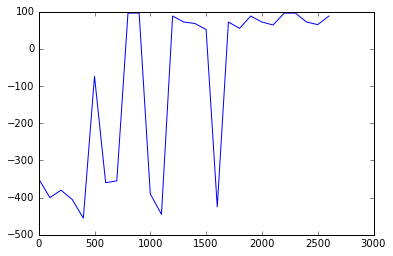

In [29]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [31]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2016-11-28 03:24:34,901] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 03:24:34,909] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 12 timesteps with reward=46.0
Episode finished after 20 timesteps with reward=3.0
Episode finished after 8 timesteps with reward=65.0
Episode finished after 5 timesteps with reward=84.0
Episode finished after 12 timesteps with reward=48.0
Episode finished after 10 timesteps with reward=59.0
Episode finished after 3 timesteps with reward=92.0
Episode finished after 5 timesteps with reward=84.0
Episode finished after 2 timesteps with reward=96.0
Episode finished after 8 timesteps with reward=65.0
Episode finished after 7 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=84.0
Episode finished after 2 timesteps with reward=96.0
Episode finished after 13 timesteps with reward=40.0
Episode finished after 8 timesteps with reward=72.0
Episode finished after 4 timesteps with reward=88.0
Episode finished after 2 timesteps with reward=96.0
Episode finished after 8 timesteps with reward=65.0


[2016-11-28 03:24:38,575] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 4 timesteps with reward=88.0
Episode finished after 2 timesteps with reward=96.0
mean session score=72.150000.5


In [32]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"doombasic_dqn_2500.pcl")

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="<writeme>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__